In [61]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

def add_naive_forecast(df, target_col, months_back, start_date, horizon_months, text):
  
    forecast_col = f"Naive: {months_back}-Month for {text}"
    df[forecast_col] = np.nan

    start = pd.to_datetime(start_date)
    end = start + pd.DateOffset(months=horizon_months - 1)
    reference_date = start - pd.DateOffset(months=months_back)

    if reference_date in df.index:
        naive_value = df[target_col][df.index < start_date].iloc[-1]
        forecast_range = (df.index >= start) & (df.index <= end)
        df.loc[forecast_range, forecast_col] = naive_value

    return df


def getMetrics(df_d, df_r, date1, date2, forecast_type):
    month_name = pd.to_datetime(date1).strftime('%B')
    mask = (df_d.index >= date1) & (df_d.index <= date2)
    y_true = df_d.loc[mask, "Actual Rate"]
    y_pred = df_d.loc[mask, forecast_type]
    forecast_type_split = forecast_type.split(" f")
    if not y_true.isna().all() and not y_pred.isna().all():
        df_r.loc[month_name, f"{forecast_type_split[0]}: MAE"] = mean_absolute_error(y_true, y_pred)
        df_r.loc[month_name, f"{forecast_type_split[0]}: RMSE"] = np.sqrt(mean_squared_error(y_true, y_pred))
    
    return df_r


In [76]:
#1 Month - Prices only
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

file_path = "../cleandata.csv"
df_clean = pd.read_csv(file_path)

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')
forecast_data = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
                 'Global price of Natural Gas, Asia (start month, MMBTU)',
                 'Global price of Natural Gas, EU (start month, MMBTU)',
                 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
                 'Spread\nEU-US',
                 'Spread\nASIA-US',
                 'Spread\nASIA-EU']
plotskip =  ['LNG Shipping Capacity (CBM)',
             'LNG Carrier Newbuilding Prices (end month, $m)',
             'LNG Orderbook (start month, CBM)',
             'Global price of Natural Gas, Asia (start month, MMBTU)',
             'Global price of Natural Gas, EU (start month, MMBTU)',
             'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
             'Spread\nEU-US',
             'Spread\nASIA-US',
             'Spread\nASIA-EU']

target = forecast_data[0]

forecast_start_date = pd.to_datetime("2024-01-01")
forecast_end_date = pd.to_datetime("2024-01-01")
df_forecast = df_clean[forecast_data].copy()
error_metrics = pd.DataFrame(columns=["Forecast Type", "MAE", "RMSE"])
error_details = pd.DataFrame()

while forecast_end_date <= pd.to_datetime("2024-12-01"):
    df_temp = df_clean[forecast_data].copy()
    df_train = df_temp[df_temp.index < forecast_start_date]
    df_train = np.log(df_train).diff().dropna()
    
    forecast_range = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq="MS")
    forecast_steps = len(forecast_range)
    model = VAR(df_train)
    selected_lag = model.select_order(maxlags=2).aic
    if selected_lag is None or selected_lag == 0:
        selected_lag = 1
    results = model.fit(maxlags=selected_lag)
    forecast = results.forecast(df_train.values, steps=forecast_steps)
    
    last_log_value = np.log(df_forecast.loc[df_train.index[-1], target])
    df_temp_forecast = pd.DataFrame(forecast, index=forecast_range, columns=df_train.columns)
    log_forecast_cumsum = df_temp_forecast[target].cumsum() + last_log_value  
    recovered_forecast = np.exp(log_forecast_cumsum) 
    forecast_label = f"Forecast {forecast_start_date.strftime('%b')} - {forecast_end_date.strftime('%b')}"
    df_forecast.loc[forecast_range, forecast_label] = recovered_forecast
    
    mask = (df_forecast.index >= forecast_start_date) & (df_forecast.index <= forecast_end_date)
    y_true = df_forecast.loc[mask, target]
    y_pred = df_forecast.loc[mask, forecast_label]
    if not y_true.isna().all() and not y_pred.isna().all():
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        error_metrics = pd.concat([error_metrics, pd.DataFrame([[forecast_label, mae, rmse]], columns=["Forecast Type", "MAE", "RMSE"])])
        details_df = pd.DataFrame({"Date": y_true.index, "Actual": y_true.values, "Forecast": y_pred.values, "Error": (y_true - y_pred).values, "Forecast Type": forecast_label})
        error_details = pd.concat([error_details, details_df])

    forecast_start_date += pd.DateOffset(months=1)
    forecast_end_date += pd.DateOffset(months=1)


error_metrics.reset_index(drop=True, inplace=True)
error_details.reset_index(drop=True, inplace=True)

print("1-Month gas prices only Forecast Error Metrics:")
display(error_metrics)
#display(error_details)
print("1-Month Gas prices only \n",
      "MAE :", round(mean_absolute_error(error_details["Actual"],error_details["Forecast"]),2),"\n",
      "RMSE:", round(np.sqrt(mean_squared_error(error_details['Actual'],error_details["Forecast"])),2))
#results.summary()


1-Month gas prices only Forecast Error Metrics:


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/folders/q_/5f9r9hrn7fgg50f9b9171j940000gn/T/ipykernel_5773/4029541629.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  error_metrics = pd.concat([error_metrics, pd.DataFrame([[forecast_label, mae, rmse]], columns=["Forecast Type", "MAE", "RMSE"])

,Forecast Type,MAE,RMSE
0,Forecast Jan - Jan,45512.286989,45512.286989
1,Forecast Feb - Feb,11358.095935,11358.095935
2,Forecast Mar - Mar,19293.425892,19293.425892
3,Forecast Apr - Apr,9560.812632,9560.812632
4,Forecast May - May,3212.175692,3212.175692
5,Forecast Jun - Jun,8378.420942,8378.420942
6,Forecast Jul - Jul,7841.633034,7841.633034
7,Forecast Aug - Aug,4424.043437,4424.043437
8,Forecast Sep - Sep,21307.125933,21307.125933
9,Forecast Oct - Oct,19154.886664,19154.886664


1-Month Gas prices only 
 MAE : 14253.13 
 RMSE: 18363.19


In [83]:
#1 Month - Gas + Fleet
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

file_path = "../cleandata.csv"
df_clean = pd.read_csv(file_path)

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')
forecast_data = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
                 'LNG Shipping Capacity (CBM)',
                 'Global price of Natural Gas, Asia (start month, MMBTU)',
                 'Global price of Natural Gas, EU (start month, MMBTU)',
                 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
                 'Spread\nEU-US',
                 'Spread\nASIA-US',
                 'Spread\nASIA-EU']
plotskip =  ['LNG Shipping Capacity (CBM)',
             'LNG Carrier Newbuilding Prices (end month, $m)',
             'LNG Orderbook (start month, CBM)',
             'Global price of Natural Gas, Asia (start month, MMBTU)',
             'Global price of Natural Gas, EU (start month, MMBTU)',
             'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
             'Spread\nEU-US',
             'Spread\nASIA-US',
             'Spread\nASIA-EU']

target = forecast_data[0]

forecast_start_date = pd.to_datetime("2024-01-01")
forecast_end_date = pd.to_datetime("2024-01-01")
df_forecast = df_clean[forecast_data].copy()
error_metrics = pd.DataFrame(columns=["Forecast Type", "MAE", "RMSE"])
error_details = pd.DataFrame()

while forecast_end_date <= pd.to_datetime("2024-12-01"): 
    df_temp = df_clean[forecast_data].copy()
    df_train = df_temp[df_temp.index < forecast_start_date]
    df_train = np.log(df_train).diff().dropna()
    
    # Generate VAR forecast
    forecast_range = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq="MS")
    forecast_steps = len(forecast_range)
    model = VAR(df_train)
    selected_lag = model.select_order(maxlags=2).aic
    if selected_lag is None or selected_lag == 0:
        selected_lag = 1
    results = model.fit(maxlags=selected_lag)
    forecast = results.forecast(df_train.values, steps=forecast_steps)
    
    # Recover the forecast values
    last_log_value = np.log(df_forecast.loc[df_train.index[-1], target])
    df_temp_forecast = pd.DataFrame(forecast, index=forecast_range, columns=df_train.columns)
    log_forecast_cumsum = df_temp_forecast[target].cumsum() + last_log_value  
    recovered_forecast = np.exp(log_forecast_cumsum) 
    forecast_label = f"Forecast {forecast_start_date.strftime('%b')} - {forecast_end_date.strftime('%b')}"
    df_forecast.loc[forecast_range, forecast_label] = recovered_forecast
    
    # Calculate error metrics
    mask = (df_forecast.index >= forecast_start_date) & (df_forecast.index <= forecast_end_date)
    y_true = df_forecast.loc[mask, target]
    y_pred = df_forecast.loc[mask, forecast_label]
    if not y_true.isna().all() and not y_pred.isna().all():
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        error_metrics = pd.concat([error_metrics, pd.DataFrame([[forecast_label, mae, rmse]], columns=["Forecast Type", "MAE", "RMSE"])])
        details_df = pd.DataFrame({"Date": y_true.index, "Actual": y_true.values, "Forecast": y_pred.values, "Error": (y_true - y_pred).values, "Forecast Type": forecast_label})
        error_details = pd.concat([error_details, details_df])
    
    # Move to the next 3-month period
    forecast_start_date += pd.DateOffset(months=1)
    forecast_end_date += pd.DateOffset(months=1)

# Reset index for cleaner output
error_metrics.reset_index(drop=True, inplace=True)
error_details.reset_index(drop=True, inplace=True)

# Display error metrics
print("1-Month Gas + Fleet Forecast Error Metrics:")
display(error_metrics)
#display(error_details)

print("1-Month Gas + Fleet \n",
      "MAE :", round(mean_absolute_error(error_details["Actual"],error_details["Forecast"]),2),"\n",
      "RMSE:", round(np.sqrt(mean_squared_error(error_details['Actual'],error_details["Forecast"])),2))
#results.summary()

1-Month Gas + Fleet Forecast Error Metrics:


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/folders/q_/5f9r9hrn7fgg50f9b9171j940000gn/T/ipykernel_5773/4017852817.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  error_metrics = pd.concat([error_metrics, pd.DataFrame([[forecast_label, mae, rmse]], columns=["Forecast Type", "MAE", "RMSE"])

,Forecast Type,MAE,RMSE
0,Forecast Jan - Jan,9370.443095,9370.443095
1,Forecast Feb - Feb,9898.778832,9898.778832
2,Forecast Mar - Mar,11887.392788,11887.392788
3,Forecast Apr - Apr,9096.622758,9096.622758
4,Forecast May - May,4113.737810,4113.737810
5,Forecast Jun - Jun,9396.128273,9396.128273
6,Forecast Jul - Jul,9972.475118,9972.475118
7,Forecast Aug - Aug,3760.497765,3760.497765
8,Forecast Sep - Sep,21238.897250,21238.897250
9,Forecast Oct - Oct,18092.232418,18092.232418


1-Month Gas + Fleet 
 MAE : 11029.03 
 RMSE: 12937.4


In [84]:
#1 Month - Full model
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

file_path = "../cleandata.csv"
df_clean = pd.read_csv(file_path)

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')
forecast_data = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
                 'LNG Shipping Capacity (CBM)',
                 'LNG Carrier Newbuilding Prices (end month, $m)',
                 'LNG Orderbook (start month, CBM)',
                 'Global price of Natural Gas, Asia (start month, MMBTU)',
                 'Global price of Natural Gas, EU (start month, MMBTU)',
                 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
                 'Spread\nEU-US',
                 'Spread\nASIA-US',
                 'Spread\nASIA-EU']
plotskip =  ['LNG Shipping Capacity (CBM)',
             'LNG Carrier Newbuilding Prices (end month, $m)',
             'LNG Orderbook (start month, CBM)',
             'Global price of Natural Gas, Asia (start month, MMBTU)',
             'Global price of Natural Gas, EU (start month, MMBTU)',
             'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
             'Spread\nEU-US',
             'Spread\nASIA-US',
             'Spread\nASIA-EU']

target = forecast_data[0]

forecast_start_date = pd.to_datetime("2024-01-01")
forecast_end_date = pd.to_datetime("2024-01-01")
df_forecast = df_clean[forecast_data].copy()
error_metrics = pd.DataFrame(columns=["Forecast Type", "MAE", "RMSE"])
error_details = pd.DataFrame()

while forecast_end_date <= pd.to_datetime("2024-12-01"):
    print(f"Forecast Period: {forecast_start_date.strftime('%b')} - {forecast_end_date.strftime('%b')}")
    
    df_temp = df_clean[forecast_data].copy()
    df_train = df_temp[df_temp.index < forecast_start_date]
    df_train = np.log(df_train).diff().dropna()
    
    # Generate VAR forecast
    forecast_range = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq="MS")
    forecast_steps = len(forecast_range)
    model = VAR(df_train)
    selected_lag = model.select_order(maxlags=2).aic
    if selected_lag is None or selected_lag == 0:
        selected_lag = 1
    results = model.fit(maxlags=selected_lag)
    forecast = results.forecast(df_train.values, steps=forecast_steps)
    
    # Recover the forecast values
    last_log_value = np.log(df_forecast.loc[df_train.index[-1], target])
    df_temp_forecast = pd.DataFrame(forecast, index=forecast_range, columns=df_train.columns)
    log_forecast_cumsum = df_temp_forecast[target].cumsum() + last_log_value  
    recovered_forecast = np.exp(log_forecast_cumsum) 
    forecast_label = f"Forecast {forecast_start_date.strftime('%b')} - {forecast_end_date.strftime('%b')}"
    df_forecast.loc[forecast_range, forecast_label] = recovered_forecast
    
    # Calculate error metrics
    mask = (df_forecast.index >= forecast_start_date) & (df_forecast.index <= forecast_end_date)
    y_true = df_forecast.loc[mask, target]
    y_pred = df_forecast.loc[mask, forecast_label]
    if not y_true.isna().all() and not y_pred.isna().all():
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        error_metrics = pd.concat([error_metrics, pd.DataFrame([[forecast_label, mae, rmse]], columns=["Forecast Type", "MAE", "RMSE"])])
        details_df = pd.DataFrame({"Date": y_true.index, "Actual": y_true.values, "Forecast": y_pred.values, "Error": (y_true - y_pred).values, "Forecast Type": forecast_label})
        error_details = pd.concat([error_details, details_df])
    
    # Move to the next 3-month period
    forecast_start_date += pd.DateOffset(months=1)
    forecast_end_date += pd.DateOffset(months=1)

# Reset index for cleaner output
error_metrics.reset_index(drop=True, inplace=True)
error_details.reset_index(drop=True, inplace=True)

# Display error metrics
print("1-Month full model Forecast Error Metrics:")
display(error_metrics)
#display(error_details)


print("1-Month full model \n",
      "MAE :", round(mean_absolute_error(error_details["Actual"],error_details["Forecast"]),2),"\n",
      "RMSE:", round(np.sqrt(mean_squared_error(error_details['Actual'],error_details["Forecast"])),2))
#results.summary()

Forecast Period: Jan - Jan
Forecast Period: Feb - Feb
Forecast Period: Mar - Mar
Forecast Period: Apr - Apr
Forecast Period: May - May
Forecast Period: Jun - Jun
Forecast Period: Jul - Jul
Forecast Period: Aug - Aug
Forecast Period: Sep - Sep
Forecast Period: Oct - Oct
Forecast Period: Nov - Nov
Forecast Period: Dec - Dec
1-Month full model Forecast Error Metrics:


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/folders/q_/5f9r9hrn7fgg50f9b9171j940000gn/T/ipykernel_5773/2491554054.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  error_metrics = pd.concat([error_metrics, pd.DataFrame([[forecast_label, mae, rmse]], columns=["Forecast Type", "MAE", "RMSE"])

,Forecast Type,MAE,RMSE
0,Forecast Jan - Jan,42565.997862,42565.997862
1,Forecast Feb - Feb,2195.136349,2195.136349
2,Forecast Mar - Mar,17069.064566,17069.064566
3,Forecast Apr - Apr,15135.061440,15135.061440
4,Forecast May - May,7287.055844,7287.055844
5,Forecast Jun - Jun,25157.585329,25157.585329
6,Forecast Jul - Jul,167.377930,167.377930
7,Forecast Aug - Aug,11282.284316,11282.284316
8,Forecast Sep - Sep,27661.448705,27661.448705
9,Forecast Oct - Oct,25483.616336,25483.616336


1-Month full model 
 MAE : 15985.82 
 RMSE: 20019.57


In [85]:
#3 Month - Prices only
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

file_path = "../cleandata.csv"
df_clean = pd.read_csv(file_path)

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')
forecast_data = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
                 'Global price of Natural Gas, Asia (start month, MMBTU)',
                 'Global price of Natural Gas, EU (start month, MMBTU)',
                 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
                 'Spread\nEU-US',
                 'Spread\nASIA-US',
                 'Spread\nASIA-EU']
plotskip =  ['LNG Shipping Capacity (CBM)',
             'LNG Carrier Newbuilding Prices (end month, $m)',
             'LNG Orderbook (start month, CBM)',
             'Global price of Natural Gas, Asia (start month, MMBTU)',
             'Global price of Natural Gas, EU (start month, MMBTU)',
             'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
             'Spread\nEU-US',
             'Spread\nASIA-US',
             'Spread\nASIA-EU']

target = forecast_data[0]

forecast_start_date = pd.to_datetime("2024-01-01")
forecast_end_date = pd.to_datetime("2024-03-01")
df_forecast = df_clean[forecast_data].copy()
error_metrics = pd.DataFrame(columns=["Forecast Type", "MAE", "RMSE"])
error_details = pd.DataFrame()

while forecast_end_date <= pd.to_datetime("2024-12-01"):
    df_temp = df_clean[forecast_data].copy()
    df_train = df_temp[df_temp.index < forecast_start_date]
    df_train = np.log(df_train).diff().dropna()
    
    # Generate VAR forecast
    forecast_range = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq="MS")
    forecast_steps = len(forecast_range)
    model = VAR(df_train)
    selected_lag = model.select_order(maxlags=2).aic
    if selected_lag is None or selected_lag == 0:
        selected_lag = 1
    results = model.fit(maxlags=selected_lag)
    forecast = results.forecast(df_train.values, steps=forecast_steps)
    
    # Recover the forecast values
    last_log_value = np.log(df_forecast.loc[df_train.index[-1], target])
    df_temp_forecast = pd.DataFrame(forecast, index=forecast_range, columns=df_train.columns)
    log_forecast_cumsum = df_temp_forecast[target].cumsum() + last_log_value  
    recovered_forecast = np.exp(log_forecast_cumsum) 
    forecast_label = f"Forecast {forecast_start_date.strftime('%b')} - {forecast_end_date.strftime('%b')}"
    df_forecast.loc[forecast_range, forecast_label] = recovered_forecast
    
    # Calculate error metrics
    mask = (df_forecast.index >= forecast_start_date) & (df_forecast.index <= forecast_end_date)
    y_true = df_forecast.loc[mask, target]
    y_pred = df_forecast.loc[mask, forecast_label]
    if not y_true.isna().all() and not y_pred.isna().all():
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        error_metrics = pd.concat([error_metrics, pd.DataFrame([[forecast_label, mae, rmse]], columns=["Forecast Type", "MAE", "RMSE"])])
        details_df = pd.DataFrame({"Date": y_true.index, "Actual": y_true.values, "Forecast": y_pred.values, "Error": (y_true - y_pred).values, "Forecast Type": forecast_label})
        error_details = pd.concat([error_details, details_df])
    
    # Move to the next 3-month period
    forecast_start_date += pd.DateOffset(months=1)
    forecast_end_date += pd.DateOffset(months=1)

# Reset index for cleaner output
error_metrics.reset_index(drop=True, inplace=True)
error_details.reset_index(drop=True, inplace=True)

# Display error metrics
print("3-Month gas prices only Forecast Error Metrics:")
display(error_metrics)
#display(error_details)


print("3-Month Gas prices only \n",
      "MAE :", round(mean_absolute_error(error_details["Actual"],error_details["Forecast"]),2),"\n",
      "RMSE:", round(np.sqrt(mean_squared_error(error_details['Actual'],error_details["Forecast"])),2))
results.summary()

3-Month gas prices only Forecast Error Metrics:


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/folders/q_/5f9r9hrn7fgg50f9b9171j940000gn/T/ipykernel_5773/1513913600.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  error_metrics = pd.concat([error_metrics, pd.DataFrame([[forecast_label, mae, rmse]], columns=["Forecast Type", "MAE", "RMSE"])

,Forecast Type,MAE,RMSE
0,Forecast Jan - Mar,52143.319484,52373.359668
1,Forecast Feb - Apr,11437.367881,11758.321286
2,Forecast Mar - May,19776.664563,20021.316924
3,Forecast Apr - Jun,6472.704253,7804.668517
4,Forecast May - Jul,15870.837984,18873.501387
5,Forecast Jun - Aug,15335.368709,16110.965235
6,Forecast Jul - Sep,6793.876157,6843.561503
7,Forecast Aug - Oct,15531.672811,20010.204772
8,Forecast Sep - Nov,50824.672584,55956.438423
9,Forecast Oct - Dec,31346.848238,32543.954709


3-Month Gas prices only 
 MAE : 22553.33 
 RMSE: 29319.34


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/vector_ar/var_model.py:1501: RuntimeWarning: divide by zero encountered in matmul
  return np.kron(np.linalg.inv(z.T @ z), self.sigma_u)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/vector_ar/var_model.py:1501: RuntimeWarning: overflow encountered in matmul
  return np.kron(np.linalg.inv(z.T @ z), self.sigma_u)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/vector_ar/var_model.py:1501: RuntimeWarning: invalid value encountered in matmul
  return np.kron(np.linalg.inv(z.T @ z), self.sigma_u)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 02, Jun, 2025
Time:                     15:40:30
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -19.1311
Nobs:                     42.0000    HQIC:                  -20.5987
Log likelihood:           89.2390    FPE:                5.00719e-10
AIC:                     -21.4479    Det(Omega_mle):     1.47757e-10
--------------------------------------------------------------------
Results for equation LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)
                                                                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------------------------------------------
const                                                             

In [87]:
#3 Month - Gas + Fleet
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

file_path = "../cleandata.csv"
df_clean = pd.read_csv(file_path)

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')
forecast_data = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
                 'LNG Shipping Capacity (CBM)',
                 'Global price of Natural Gas, Asia (start month, MMBTU)',
                 'Global price of Natural Gas, EU (start month, MMBTU)',
                 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
                 'Spread\nEU-US',
                 'Spread\nASIA-US',
                 'Spread\nASIA-EU']
plotskip =  ['LNG Shipping Capacity (CBM)',
             'LNG Carrier Newbuilding Prices (end month, $m)',
             'LNG Orderbook (start month, CBM)',
             'Global price of Natural Gas, Asia (start month, MMBTU)',
             'Global price of Natural Gas, EU (start month, MMBTU)',
             'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
             'Spread\nEU-US',
             'Spread\nASIA-US',
             'Spread\nASIA-EU']

target = forecast_data[0]

forecast_start_date = pd.to_datetime("2024-01-01")
forecast_end_date = pd.to_datetime("2024-03-01")
df_forecast = df_clean[forecast_data].copy()
error_metrics = pd.DataFrame(columns=["Forecast Type", "MAE", "RMSE"])
error_details = pd.DataFrame()

while forecast_end_date <= pd.to_datetime("2024-12-01"):
    df_temp = df_clean[forecast_data].copy()
    df_train = df_temp[df_temp.index < forecast_start_date]
    df_train = np.log(df_train).diff().dropna()
    
    # Generate VAR forecast
    forecast_range = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq="MS")
    forecast_steps = len(forecast_range)
    model = VAR(df_train)
    selected_lag = model.select_order(maxlags=2).aic
    if selected_lag is None or selected_lag == 0:
        selected_lag = 1
    results = model.fit(maxlags=selected_lag)
    forecast = results.forecast(df_train.values, steps=forecast_steps)
    
    # Recover the forecast values
    last_log_value = np.log(df_forecast.loc[df_train.index[-1], target])
    df_temp_forecast = pd.DataFrame(forecast, index=forecast_range, columns=df_train.columns)
    log_forecast_cumsum = df_temp_forecast[target].cumsum() + last_log_value  
    recovered_forecast = np.exp(log_forecast_cumsum) 
    forecast_label = f"Forecast {forecast_start_date.strftime('%b')} - {forecast_end_date.strftime('%b')}"
    df_forecast.loc[forecast_range, forecast_label] = recovered_forecast
    
    # Calculate error metrics
    mask = (df_forecast.index >= forecast_start_date) & (df_forecast.index <= forecast_end_date)
    y_true = df_forecast.loc[mask, target]
    y_pred = df_forecast.loc[mask, forecast_label]
    if not y_true.isna().all() and not y_pred.isna().all():
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        error_metrics = pd.concat([error_metrics, pd.DataFrame([[forecast_label, mae, rmse]], columns=["Forecast Type", "MAE", "RMSE"])])
        details_df = pd.DataFrame({"Date": y_true.index, "Actual": y_true.values, "Forecast": y_pred.values, "Error": (y_true - y_pred).values, "Forecast Type": forecast_label})
        error_details = pd.concat([error_details, details_df])
    
    # Move to the next 3-month period
    forecast_start_date += pd.DateOffset(months=1)
    forecast_end_date += pd.DateOffset(months=1)

# Reset index for cleaner output
error_metrics.reset_index(drop=True, inplace=True)
#error_details.reset_index(drop=True, inplace=True)

# Display error metrics
print("3-Month Gas + Fleet Forecast Error Metrics:")
display(error_metrics)
#display(error_details)


print("3-Month Gas + Fleet \n",
      "MAE :", round(mean_absolute_error(error_details["Actual"],error_details["Forecast"]),2),"\n",
      "RMSE:", round(np.sqrt(mean_squared_error(error_details['Actual'],error_details["Forecast"])),2))
#results.summary()

3-Month Gas + Fleet Forecast Error Metrics:


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/folders/q_/5f9r9hrn7fgg50f9b9171j940000gn/T/ipykernel_5773/3906803049.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  error_metrics = pd.concat([error_metrics, pd.DataFrame([[forecast_label, mae, rmse]], columns=["Forecast Type", "MAE", "RMSE"])

,Forecast Type,MAE,RMSE
0,Forecast Jan - Mar,15403.350323,16526.451051
1,Forecast Feb - Apr,25097.063590,27508.286971
2,Forecast Mar - May,18561.543793,19164.890027
3,Forecast Apr - Jun,6585.023783,7191.915045
4,Forecast May - Jul,17222.027203,20148.373994
5,Forecast Jun - Aug,16134.889984,16846.509351
6,Forecast Jul - Sep,7588.182776,9013.201493
7,Forecast Aug - Oct,14963.732532,19195.037494
8,Forecast Sep - Nov,51394.868962,56728.070191
9,Forecast Oct - Dec,29270.046661,30347.190796


3-Month Gas + Fleet 
 MAE : 20222.07 
 RMSE: 25937.08


In [82]:
#3 Month - Full model
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

file_path = "../cleandata.csv"
df_clean = pd.read_csv(file_path)

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')
forecast_data = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
                 'LNG Shipping Capacity (CBM)',
                 'LNG Carrier Newbuilding Prices (end month, $m)',
                 'LNG Orderbook (start month, CBM)',
                 'Global price of Natural Gas, Asia (start month, MMBTU)',
                 'Global price of Natural Gas, EU (start month, MMBTU)',
                 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
                 'Spread\nEU-US',
                 'Spread\nASIA-US',
                 'Spread\nASIA-EU']
plotskip =  ['LNG Shipping Capacity (CBM)',
             'LNG Carrier Newbuilding Prices (end month, $m)',
             'LNG Orderbook (start month, CBM)',
             'Global price of Natural Gas, Asia (start month, MMBTU)',
             'Global price of Natural Gas, EU (start month, MMBTU)',
             'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
             'Spread\nEU-US',
             'Spread\nASIA-US',
             'Spread\nASIA-EU']

target = forecast_data[0]

forecast_start_date = pd.to_datetime("2024-01-01")
forecast_end_date = pd.to_datetime("2024-03-01")
df_forecast = df_clean[forecast_data].copy()
error_metrics = pd.DataFrame(columns=["Forecast Type", "MAE", "RMSE"])
error_details = pd.DataFrame()

while forecast_end_date <= pd.to_datetime("2024-12-01"):
    df_temp = df_clean[forecast_data].copy()
    df_train = df_temp[df_temp.index < forecast_start_date]
    df_train = np.log(df_train).diff().dropna()
    
    # Generate VAR forecast
    forecast_range = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq="MS")
    forecast_steps = len(forecast_range)
    model = VAR(df_train)
    selected_lag = model.select_order(maxlags=2).aic
    if selected_lag is None or selected_lag == 0:
        selected_lag = 1
    results = model.fit(maxlags=selected_lag)
    forecast = results.forecast(df_train.values, steps=forecast_steps)
    
    # Recover the forecast values
    last_log_value = np.log(df_forecast.loc[df_train.index[-1], target])
    df_temp_forecast = pd.DataFrame(forecast, index=forecast_range, columns=df_train.columns)
    log_forecast_cumsum = df_temp_forecast[target].cumsum() + last_log_value  
    recovered_forecast = np.exp(log_forecast_cumsum) 
    forecast_label = f"Forecast {forecast_start_date.strftime('%b')} - {forecast_end_date.strftime('%b')}"
    df_forecast.loc[forecast_range, forecast_label] = recovered_forecast
    
    # Calculate error metrics
    mask = (df_forecast.index >= forecast_start_date) & (df_forecast.index <= forecast_end_date)
    y_true = df_forecast.loc[mask, target]
    y_pred = df_forecast.loc[mask, forecast_label]
    if not y_true.isna().all() and not y_pred.isna().all():
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        error_metrics = pd.concat([error_metrics, pd.DataFrame([[forecast_label, mae, rmse]], columns=["Forecast Type", "MAE", "RMSE"])])
        details_df = pd.DataFrame({"Date": y_true.index, "Actual": y_true.values, "Forecast": y_pred.values, "Error": (y_true - y_pred).values, "Forecast Type": forecast_label})
        error_details = pd.concat([error_details, details_df])
    
    # Move to the next 3-month period
    forecast_start_date += pd.DateOffset(months=1)
    forecast_end_date += pd.DateOffset(months=1)

# Reset index for cleaner output
error_metrics.reset_index(drop=True, inplace=True)
error_details.reset_index(drop=True, inplace=True)

# Display error metrics
print("3-Month full model Forecast Error Metrics:")
display(error_metrics)
#display(error_details)


print("3-Month full model \n",
      "MAE :", round(mean_absolute_error(error_details["Actual"],error_details["Forecast"]),2),"\n",
      "RMSE:", round(np.sqrt(mean_squared_error(error_details['Actual'],error_details["Forecast"])),2))
#results.summary()

3-Month full model Forecast Error Metrics:


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/folders/q_/5f9r9hrn7fgg50f9b9171j940000gn/T/ipykernel_5773/3162189223.py:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  error_metrics = pd.concat([error_metrics, pd.DataFrame([[forecast_label, mae, rmse]], columns=["Forecast Type", "MAE", "RMSE"])

,Forecast Type,MAE,RMSE
0,Forecast Jan - Mar,29943.715515,33256.770940
1,Forecast Feb - Apr,5405.935706,6936.067372
2,Forecast Mar - May,27839.236317,28898.944524
3,Forecast Apr - Jun,17105.739889,17365.008109
4,Forecast May - Jul,25821.411271,29842.006830
5,Forecast Jun - Aug,32310.996000,32717.031355
6,Forecast Jul - Sep,3840.569379,4819.571314
7,Forecast Aug - Oct,13344.261480,15585.669635
8,Forecast Sep - Nov,55035.586326,59217.768036
9,Forecast Oct - Dec,33980.131071,34522.426163


3-Month full model 
 MAE : 24462.76 
 RMSE: 30358.6


In [81]:
#6 Month - Prices only
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

file_path = "../cleandata.csv"
df_clean = pd.read_csv(file_path)

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')
forecast_data = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
                 'Global price of Natural Gas, Asia (start month, MMBTU)',
                 'Global price of Natural Gas, EU (start month, MMBTU)',
                 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
                 'Spread\nEU-US',
                 'Spread\nASIA-US',
                 'Spread\nASIA-EU']
plotskip =  ['LNG Shipping Capacity (CBM)',
             'LNG Carrier Newbuilding Prices (end month, $m)',
             'LNG Orderbook (start month, CBM)',
             'Global price of Natural Gas, Asia (start month, MMBTU)',
             'Global price of Natural Gas, EU (start month, MMBTU)',
             'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
             'Spread\nEU-US',
             'Spread\nASIA-US',
             'Spread\nASIA-EU']

target = forecast_data[0]

forecast_start_date = pd.to_datetime("2024-01-01")
forecast_end_date = pd.to_datetime("2024-06-01")
df_forecast = df_clean[forecast_data].copy()
error_metrics = pd.DataFrame(columns=["Forecast Type", "MAE", "RMSE"])
error_details = pd.DataFrame()

while forecast_end_date <= pd.to_datetime("2024-12-01"):
    df_temp = df_clean[forecast_data].copy()
    df_train = df_temp[df_temp.index < forecast_start_date]
    df_train = np.log(df_train).diff().dropna()
    
    # Generate VAR forecast
    forecast_range = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq="MS")
    forecast_steps = len(forecast_range)
    model = VAR(df_train)
    selected_lag = model.select_order(maxlags=2).aic
    if selected_lag is None or selected_lag == 0:
        selected_lag = 1
    results = model.fit(maxlags=selected_lag)
    forecast = results.forecast(df_train.values, steps=forecast_steps)
    
    # Recover the forecast values
    last_log_value = np.log(df_forecast.loc[df_train.index[-1], target])
    df_temp_forecast = pd.DataFrame(forecast, index=forecast_range, columns=df_train.columns)
    log_forecast_cumsum = df_temp_forecast[target].cumsum() + last_log_value  
    recovered_forecast = np.exp(log_forecast_cumsum) 
    forecast_label = f"Forecast {forecast_start_date.strftime('%b')} - {forecast_end_date.strftime('%b')}"
    df_forecast.loc[forecast_range, forecast_label] = recovered_forecast
    
    # Calculate error metrics
    mask = (df_forecast.index >= forecast_start_date) & (df_forecast.index <= forecast_end_date)
    y_true = df_forecast.loc[mask, target]
    y_pred = df_forecast.loc[mask, forecast_label]
    if not y_true.isna().all() and not y_pred.isna().all():
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        error_metrics = pd.concat([error_metrics, pd.DataFrame([[forecast_label, mae, rmse]], columns=["Forecast Type", "MAE", "RMSE"])])
        details_df = pd.DataFrame({"Date": y_true.index, "Actual": y_true.values, "Forecast": y_pred.values, "Error": (y_true - y_pred).values, "Forecast Type": forecast_label})
        error_details = pd.concat([error_details, details_df])
    
    # Move to the next 3-month period
    forecast_start_date += pd.DateOffset(months=1)
    forecast_end_date += pd.DateOffset(months=1)

# Reset index for cleaner output
error_metrics.reset_index(drop=True, inplace=True)
error_details.reset_index(drop=True, inplace=True)

# Display error metrics
print("6-Month gas prices only Forecast Error Metrics:")
display(error_metrics)
#display(error_details)

print("6-Month Gas prices only \n",
      "MAE :", round(mean_absolute_error(error_details["Actual"],error_details["Forecast"]),2),"\n",
      "RMSE:", round(np.sqrt(mean_squared_error(error_details['Actual'],error_details["Forecast"])),2))


6-Month gas prices only Forecast Error Metrics:


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/folders/q_/5f9r9hrn7fgg50f9b9171j940000gn/T/ipykernel_5773/166848748.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  error_metrics = pd.concat([error_metrics, pd.DataFrame([[forecast_label, mae, rmse]], columns=["Forecast Type", "MAE", "RMSE"])]

,Forecast Type,MAE,RMSE
0,Forecast Jan - Jun,57645.661573,58047.292177
1,Forecast Feb - Jul,9574.253344,10406.715477
2,Forecast Mar - Aug,32874.066863,35756.553537
3,Forecast Apr - Sep,6955.446757,7821.376737
4,Forecast May - Oct,16539.225864,19320.612944
5,Forecast Jun - Nov,17837.171790,20405.333129
6,Forecast Jul - Dec,26686.923761,34350.213355


6-Month Gas prices only 
 MAE : 24016.11 
 RMSE: 31138.16


In [88]:
#6 Month - Gas + Fleet
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

file_path = "../cleandata.csv"
df_clean = pd.read_csv(file_path)

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')
forecast_data = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
                 'LNG Shipping Capacity (CBM)',
                 'Global price of Natural Gas, Asia (start month, MMBTU)',
                 'Global price of Natural Gas, EU (start month, MMBTU)',
                 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
                 'Spread\nEU-US',
                 'Spread\nASIA-US',
                 'Spread\nASIA-EU']
plotskip =  ['LNG Shipping Capacity (CBM)',
             'LNG Carrier Newbuilding Prices (end month, $m)',
             'LNG Orderbook (start month, CBM)',
             'Global price of Natural Gas, Asia (start month, MMBTU)',
             'Global price of Natural Gas, EU (start month, MMBTU)',
             'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
             'Spread\nEU-US',
             'Spread\nASIA-US',
             'Spread\nASIA-EU']

target = forecast_data[0]

forecast_start_date = pd.to_datetime("2024-01-01")
forecast_end_date = pd.to_datetime("2024-06-01")
df_forecast = df_clean[forecast_data].copy()
error_metrics = pd.DataFrame(columns=["Forecast Type", "MAE", "RMSE"])
error_details = pd.DataFrame()

while forecast_end_date <= pd.to_datetime("2024-12-01"): 
    df_temp = df_clean[forecast_data].copy()
    df_train = df_temp[df_temp.index < forecast_start_date]
    df_train = np.log(df_train).diff().dropna()
    
    # Generate VAR forecast
    forecast_range = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq="MS")
    forecast_steps = len(forecast_range)
    model = VAR(df_train)
    selected_lag = model.select_order(maxlags=2).aic
    if selected_lag is None or selected_lag == 0:
        selected_lag = 1
    results = model.fit(maxlags=selected_lag)
    forecast = results.forecast(df_train.values, steps=forecast_steps)
    
    # Recover the forecast values
    last_log_value = np.log(df_forecast.loc[df_train.index[-1], target])
    df_temp_forecast = pd.DataFrame(forecast, index=forecast_range, columns=df_train.columns)
    log_forecast_cumsum = df_temp_forecast[target].cumsum() + last_log_value  
    recovered_forecast = np.exp(log_forecast_cumsum) 
    forecast_label = f"Forecast {forecast_start_date.strftime('%b')} - {forecast_end_date.strftime('%b')}"
    df_forecast.loc[forecast_range, forecast_label] = recovered_forecast
    
    # Calculate error metrics
    mask = (df_forecast.index >= forecast_start_date) & (df_forecast.index <= forecast_end_date)
    y_true = df_forecast.loc[mask, target]
    y_pred = df_forecast.loc[mask, forecast_label]
    if not y_true.isna().all() and not y_pred.isna().all():
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        error_metrics = pd.concat([error_metrics, pd.DataFrame([[forecast_label, mae, rmse]], columns=["Forecast Type", "MAE", "RMSE"])])
        details_df = pd.DataFrame({"Date": y_true.index, "Actual": y_true.values, "Forecast": y_pred.values, "Error": (y_true - y_pred).values, "Forecast Type": forecast_label})
        error_details = pd.concat([error_details, details_df])
    
    # Move to the next 3-month period
    forecast_start_date += pd.DateOffset(months=1)
    forecast_end_date += pd.DateOffset(months=1)

# Reset index for cleaner output
error_metrics.reset_index(drop=True, inplace=True)
#error_details.reset_index(drop=True, inplace=True)

# Display error metrics
print("6-Month Gas + Fleet Forecast Error Metrics:")
display(error_metrics)
#display(error_details)


print("6-Month Gas + Fleet \n",
      "MAE :", round(mean_absolute_error(error_details["Actual"],error_details["Forecast"]),2),"\n",
      "RMSE:", round(np.sqrt(mean_squared_error(error_details['Actual'],error_details["Forecast"])),2))
#results.summary()

6-Month Gas + Fleet Forecast Error Metrics:


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/folders/q_/5f9r9hrn7fgg50f9b9171j940000gn/T/ipykernel_5773/1646426645.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  error_metrics = pd.concat([error_metrics, pd.DataFrame([[forecast_label, mae, rmse]], columns=["Forecast Type", "MAE", "RMSE"])

,Forecast Type,MAE,RMSE
0,Forecast Jan - Jun,39773.547089,47306.769006
1,Forecast Feb - Jul,17899.864955,21898.803716
2,Forecast Mar - Aug,28459.045317,30808.874135
3,Forecast Apr - Sep,7416.644916,8757.619849
4,Forecast May - Oct,17449.645621,20543.422340
5,Forecast Jun - Nov,18368.404068,20888.733012
6,Forecast Jul - Dec,22784.225794,28740.036359


6-Month Gas + Fleet 
 MAE : 21735.91 
 RMSE: 27845.83


In [70]:
#6 Month - Full model
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

file_path = "../cleandata.csv"
df_clean = pd.read_csv(file_path)

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')
forecast_data = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
                 'LNG Shipping Capacity (CBM)',
                 'LNG Carrier Newbuilding Prices (end month, $m)',
                 'LNG Orderbook (start month, CBM)',
                 'Global price of Natural Gas, Asia (start month, MMBTU)',
                 'Global price of Natural Gas, EU (start month, MMBTU)',
                 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
                 'Spread\nEU-US',
                 'Spread\nASIA-US',
                 'Spread\nASIA-EU']
plotskip =  ['LNG Shipping Capacity (CBM)',
             'LNG Carrier Newbuilding Prices (end month, $m)',
             'LNG Orderbook (start month, CBM)',
             'Global price of Natural Gas, Asia (start month, MMBTU)',
             'Global price of Natural Gas, EU (start month, MMBTU)',
             'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
             'Spread\nEU-US',
             'Spread\nASIA-US',
             'Spread\nASIA-EU']

target = forecast_data[0]

forecast_start_date = pd.to_datetime("2024-01-01")
forecast_end_date = pd.to_datetime("2024-06-01")
df_forecast = df_clean[forecast_data].copy()
error_metrics = pd.DataFrame(columns=["Forecast Type", "MAE", "RMSE"])
error_details = pd.DataFrame()

while forecast_end_date <= pd.to_datetime("2024-12-01"):   
    df_temp = df_clean[forecast_data].copy()
    df_train = df_temp[df_temp.index < forecast_start_date]
    df_train = np.log(df_train).diff().dropna()
    
    # Generate VAR forecast
    forecast_range = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq="MS")
    forecast_steps = len(forecast_range)
    model = VAR(df_train)
    selected_lag = model.select_order(maxlags=2).aic
    if selected_lag is None or selected_lag == 0:
        selected_lag = 1
    results = model.fit(maxlags=selected_lag)
    forecast = results.forecast(df_train.values, steps=forecast_steps)
    
    # Recover the forecast values
    last_log_value = np.log(df_forecast.loc[df_train.index[-1], target])
    df_temp_forecast = pd.DataFrame(forecast, index=forecast_range, columns=df_train.columns)
    log_forecast_cumsum = df_temp_forecast[target].cumsum() + last_log_value  
    recovered_forecast = np.exp(log_forecast_cumsum) 
    forecast_label = f"Forecast {forecast_start_date.strftime('%b')} - {forecast_end_date.strftime('%b')}"
    df_forecast.loc[forecast_range, forecast_label] = recovered_forecast
    
    # Calculate error metrics
    mask = (df_forecast.index >= forecast_start_date) & (df_forecast.index <= forecast_end_date)
    y_true = df_forecast.loc[mask, target]
    y_pred = df_forecast.loc[mask, forecast_label]
    if not y_true.isna().all() and not y_pred.isna().all():
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        error_metrics = pd.concat([error_metrics, pd.DataFrame([[forecast_label, mae, rmse]], columns=["Forecast Type", "MAE", "RMSE"])])
        details_df = pd.DataFrame({"Date": y_true.index, "Actual": y_true.values, "Forecast": y_pred.values, "Error": (y_true - y_pred).values, "Forecast Type": forecast_label})
        error_details = pd.concat([error_details, details_df])
    
    # Move to the next 3-month period
    forecast_start_date += pd.DateOffset(months=1)
    forecast_end_date += pd.DateOffset(months=1)

# Reset index for cleaner output
error_metrics.reset_index(drop=True, inplace=True)
error_details.reset_index(drop=True, inplace=True)

# Display error metrics
print("6-Month full model Forecast Error Metrics:")
display(error_metrics)
#display(error_details)


print("6-Month full model \n",
      "MAE :", round(mean_absolute_error(error_details["Actual"],error_details["Forecast"]),2),"\n",
      "RMSE:", round(np.sqrt(mean_squared_error(error_details['Actual'],error_details["Forecast"])),2))


6-Month full model Forecast Error Metrics:


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/folders/q_/5f9r9hrn7fgg50f9b9171j940000gn/T/ipykernel_5773/528706386.py:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  error_metrics = pd.concat([error_metrics, pd.DataFrame([[forecast_label, mae, rmse]], columns=["Forecast Type", "MAE", "RMSE"])]

,Forecast Type,MAE,RMSE
0,Forecast Jan - Jun,47866.155067,53681.516429
1,Forecast Feb - Jul,14600.925431,19196.130607
2,Forecast Mar - Aug,40012.253256,42468.544245
3,Forecast Apr - Sep,12430.104728,13878.282159
4,Forecast May - Oct,28092.202348,31622.276636
5,Forecast Jun - Nov,23701.280649,26278.709746
6,Forecast Jul - Dec,24659.194233,33290.530937


6-Month full model 
 MAE : 27337.45 
 RMSE: 33901.49


In [71]:
#12 Month - Prices only
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

file_path = "../cleandata.csv"
df_clean = pd.read_csv(file_path)

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')
forecast_data = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
                 'Global price of Natural Gas, Asia (start month, MMBTU)',
                 'Global price of Natural Gas, EU (start month, MMBTU)',
                 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
                 'Spread\nEU-US',
                 'Spread\nASIA-US',
                 'Spread\nASIA-EU']
plotskip =  ['LNG Shipping Capacity (CBM)',
             'LNG Carrier Newbuilding Prices (end month, $m)',
             'LNG Orderbook (start month, CBM)',
             'Global price of Natural Gas, Asia (start month, MMBTU)',
             'Global price of Natural Gas, EU (start month, MMBTU)',
             'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
             'Spread\nEU-US',
             'Spread\nASIA-US',
             'Spread\nASIA-EU']

target = forecast_data[0]

forecast_start_date = pd.to_datetime("2024-01-01")
forecast_end_date = pd.to_datetime("2024-12-01")
df_forecast = df_clean[forecast_data].copy()
error_metrics = pd.DataFrame(columns=["Forecast Type", "MAE", "RMSE"])
error_details = pd.DataFrame()

while forecast_end_date <= pd.to_datetime("2024-12-01"): 
    df_temp = df_clean[forecast_data].copy()
    df_train = df_temp[df_temp.index < forecast_start_date]
    df_train = np.log(df_train).diff().dropna()
    
    # Generate VAR forecast
    forecast_range = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq="MS")
    forecast_steps = len(forecast_range)
    model = VAR(df_train)
    selected_lag = model.select_order(maxlags=2).aic
    if selected_lag is None or selected_lag == 0:
        selected_lag = 1
    results = model.fit(maxlags=selected_lag)
    forecast = results.forecast(df_train.values, steps=forecast_steps)
    
    # Recover the forecast values
    last_log_value = np.log(df_forecast.loc[df_train.index[-1], target])
    df_temp_forecast = pd.DataFrame(forecast, index=forecast_range, columns=df_train.columns)
    log_forecast_cumsum = df_temp_forecast[target].cumsum() + last_log_value  
    recovered_forecast = np.exp(log_forecast_cumsum) 
    forecast_label = f"Forecast {forecast_start_date.strftime('%b')} - {forecast_end_date.strftime('%b')}"
    df_forecast.loc[forecast_range, forecast_label] = recovered_forecast
    
    # Calculate error metrics
    mask = (df_forecast.index >= forecast_start_date) & (df_forecast.index <= forecast_end_date)
    y_true = df_forecast.loc[mask, target]
    y_pred = df_forecast.loc[mask, forecast_label]
    if not y_true.isna().all() and not y_pred.isna().all():
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        error_metrics = pd.concat([error_metrics, pd.DataFrame([[forecast_label, mae, rmse]], columns=["Forecast Type", "MAE", "RMSE"])])
        details_df = pd.DataFrame({"Date": y_true.index, "Actual": y_true.values, "Forecast": y_pred.values, "Error": (y_true - y_pred).values, "Forecast Type": forecast_label})
        error_details = pd.concat([error_details, details_df])
    
    # Move to the next 3-month period
    forecast_start_date += pd.DateOffset(months=1)
    forecast_end_date += pd.DateOffset(months=1)

# Reset index for cleaner output
error_metrics.reset_index(drop=True, inplace=True)
error_details.reset_index(drop=True, inplace=True)

# Display error metrics
print("12-Month gas prices only Forecast Error Metrics:")
display(error_metrics)
display(error_details)

print("12-Month Gas prices only \n",
      "MAE :", round(mean_absolute_error(error_details["Actual"],error_details["Forecast"]),2),"\n",
      "RMSE:", round(np.sqrt(mean_squared_error(error_details['Actual'],error_details["Forecast"])),2))


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


12-Month gas prices only Forecast Error Metrics:


/var/folders/q_/5f9r9hrn7fgg50f9b9171j940000gn/T/ipykernel_5773/395190845.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  error_metrics = pd.concat([error_metrics, pd.DataFrame([[forecast_label, mae, rmse]], columns=["Forecast Type", "MAE", "RMSE"])])


,Forecast Type,MAE,RMSE
0,Forecast Jan - Dec,76004.534913,82077.206256


,Date,Actual,Forecast,Error,Forecast Type
0,2024-01-01,69750.0,115262.286989,-45512.286989,Forecast Jan - Dec
1,2024-02-01,52375.0,109590.710860,-57215.710860,Forecast Jan - Dec
2,2024-03-01,53950.0,107651.960602,-53701.960602,Forecast Jan - Dec
3,2024-04-01,47562.5,111872.659015,-64310.159015,Forecast Jan - Dec
4,2024-05-01,50700.0,116657.011443,-65957.011443,Forecast Jan - Dec
5,2024-06-01,63312.5,122489.340528,-59176.840528,Forecast Jan - Dec
6,2024-07-01,75562.5,128659.902425,-53097.402425,Forecast Jan - Dec
7,2024-08-01,76800.0,135347.759374,-58547.759374,Forecast Jan - Dec
8,2024-09-01,67000.0,142436.179237,-75436.179237,Forecast Jan - Dec
9,2024-10-01,45312.5,149944.396475,-104631.896475,Forecast Jan - Dec


12-Month Gas prices only 
 MAE : 76004.53 
 RMSE: 82077.21


In [90]:
#12 Month - Gas + Fleet
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

file_path = "../cleandata.csv"
df_clean = pd.read_csv(file_path)

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')
forecast_data = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
                 'LNG Shipping Capacity (CBM)',
                 'Global price of Natural Gas, Asia (start month, MMBTU)',
                 'Global price of Natural Gas, EU (start month, MMBTU)',
                 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
                 'Spread\nEU-US',
                 'Spread\nASIA-US',
                 'Spread\nASIA-EU']
plotskip =  ['LNG Shipping Capacity (CBM)',
             'LNG Carrier Newbuilding Prices (end month, $m)',
             'LNG Orderbook (start month, CBM)',
             'Global price of Natural Gas, Asia (start month, MMBTU)',
             'Global price of Natural Gas, EU (start month, MMBTU)',
             'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
             'Spread\nEU-US',
             'Spread\nASIA-US',
             'Spread\nASIA-EU']

target = forecast_data[0]

forecast_start_date = pd.to_datetime("2024-01-01")
forecast_end_date = pd.to_datetime("2024-12-01")
df_forecast = df_clean[forecast_data].copy()
error_metrics = pd.DataFrame(columns=["Forecast Type", "MAE", "RMSE"])
error_details = pd.DataFrame()

while forecast_end_date <= pd.to_datetime("2024-12-01"):   
    df_temp = df_clean[forecast_data].copy()
    df_train = df_temp[df_temp.index < forecast_start_date]
    df_train = np.log(df_train).diff().dropna()
    
    # Generate VAR forecast
    forecast_range = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq="MS")
    forecast_steps = len(forecast_range)
    model = VAR(df_train)
    selected_lag = model.select_order(maxlags=2).aic
    if selected_lag is None or selected_lag == 0:
        selected_lag = 1
    results = model.fit(maxlags=selected_lag)
    forecast = results.forecast(df_train.values, steps=forecast_steps)
    
    # Recover the forecast values
    last_log_value = np.log(df_forecast.loc[df_train.index[-1], target])
    df_temp_forecast = pd.DataFrame(forecast, index=forecast_range, columns=df_train.columns)
    log_forecast_cumsum = df_temp_forecast[target].cumsum() + last_log_value  
    recovered_forecast = np.exp(log_forecast_cumsum) 
    forecast_label = f"Forecast {forecast_start_date.strftime('%b')} - {forecast_end_date.strftime('%b')}"
    df_forecast.loc[forecast_range, forecast_label] = recovered_forecast
    
    # Calculate error metrics
    mask = (df_forecast.index >= forecast_start_date) & (df_forecast.index <= forecast_end_date)
    y_true = df_forecast.loc[mask, target]
    y_pred = df_forecast.loc[mask, forecast_label]
    if not y_true.isna().all() and not y_pred.isna().all():
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        error_metrics = pd.concat([error_metrics, pd.DataFrame([[forecast_label, mae, rmse]], columns=["Forecast Type", "MAE", "RMSE"])])
        details_df = pd.DataFrame({"Date": y_true.index, "Actual": y_true.values, "Forecast": y_pred.values, "Error": (y_true - y_pred).values, "Forecast Type": forecast_label})
        error_details = pd.concat([error_details, details_df])
    
    # Move to the next 3-month period
    forecast_start_date += pd.DateOffset(months=1)
    forecast_end_date += pd.DateOffset(months=1)

# Reset index for cleaner output
error_metrics.reset_index(drop=True, inplace=True)
error_details.reset_index(drop=True, inplace=True)

# Display error metrics
print("12-Month Gas + Fleet Forecast Error Metrics:")
display(error_metrics)


print("12-Month Gas + Fleet \n",
      "MAE :", round(mean_absolute_error(error_details["Actual"],error_details["Forecast"]),2),"\n",
      "RMSE:", round(np.sqrt(mean_squared_error(error_details['Actual'],error_details["Forecast"])),2))

12-Month Gas + Fleet Forecast Error Metrics:


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/folders/q_/5f9r9hrn7fgg50f9b9171j940000gn/T/ipykernel_5773/1732935245.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  error_metrics = pd.concat([error_metrics, pd.DataFrame([[forecast_label, mae, rmse]], columns=["Forecast Type", "MAE", "RMSE"])

,Forecast Type,MAE,RMSE
0,Forecast Jan - Dec,51120.727615,60245.26117


12-Month Gas + Fleet 
 MAE : 51120.73 
 RMSE: 60245.26


In [73]:
#12 Month - Full model
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

file_path = "../cleandata.csv"
df_clean = pd.read_csv(file_path)

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')
forecast_data = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
                 'LNG Shipping Capacity (CBM)',
                 'LNG Carrier Newbuilding Prices (end month, $m)',
                 'LNG Orderbook (start month, CBM)',
                 'Global price of Natural Gas, Asia (start month, MMBTU)',
                 'Global price of Natural Gas, EU (start month, MMBTU)',
                 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
                 'Spread\nEU-US',
                 'Spread\nASIA-US',
                 'Spread\nASIA-EU']
plotskip =  ['LNG Shipping Capacity (CBM)',
             'LNG Carrier Newbuilding Prices (end month, $m)',
             'LNG Orderbook (start month, CBM)',
             'Global price of Natural Gas, Asia (start month, MMBTU)',
             'Global price of Natural Gas, EU (start month, MMBTU)',
             'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
             'Spread\nEU-US',
             'Spread\nASIA-US',
             'Spread\nASIA-EU']

target = forecast_data[0]

forecast_start_date = pd.to_datetime("2024-01-01")
forecast_end_date = pd.to_datetime("2024-12-01")
df_forecast = df_clean[forecast_data].copy()
error_metrics = pd.DataFrame(columns=["Forecast Type", "MAE", "RMSE"])
error_details = pd.DataFrame()

while forecast_end_date <= pd.to_datetime("2024-12-01"):
    print(f"Forecast Period: {forecast_start_date.strftime('%b')} - {forecast_end_date.strftime('%b')}")
    
    df_temp = df_clean[forecast_data].copy()
    df_train = df_temp[df_temp.index < forecast_start_date]
    df_train = np.log(df_train).diff().dropna()
    
    # Generate VAR forecast
    forecast_range = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq="MS")
    forecast_steps = len(forecast_range)
    model = VAR(df_train)
    selected_lag = model.select_order(maxlags=2).aic
    if selected_lag is None or selected_lag == 0:
        selected_lag = 1
    results = model.fit(maxlags=selected_lag)
    forecast = results.forecast(df_train.values, steps=forecast_steps)
    
    # Recover the forecast values
    last_log_value = np.log(df_forecast.loc[df_train.index[-1], target])
    df_temp_forecast = pd.DataFrame(forecast, index=forecast_range, columns=df_train.columns)
    log_forecast_cumsum = df_temp_forecast[target].cumsum() + last_log_value  
    recovered_forecast = np.exp(log_forecast_cumsum) 
    forecast_label = f"Forecast {forecast_start_date.strftime('%b')} - {forecast_end_date.strftime('%b')}"
    df_forecast.loc[forecast_range, forecast_label] = recovered_forecast
    
    # Calculate error metrics
    mask = (df_forecast.index >= forecast_start_date) & (df_forecast.index <= forecast_end_date)
    y_true = df_forecast.loc[mask, target]
    y_pred = df_forecast.loc[mask, forecast_label]
    if not y_true.isna().all() and not y_pred.isna().all():
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        error_metrics = pd.concat([error_metrics, pd.DataFrame([[forecast_label, mae, rmse]], columns=["Forecast Type", "MAE", "RMSE"])])
        details_df = pd.DataFrame({"Date": y_true.index, "Actual": y_true.values, "Forecast": y_pred.values, "Error": (y_true - y_pred).values, "Forecast Type": forecast_label})
        error_details = pd.concat([error_details, details_df])
    
    # Move to the next 3-month period
    forecast_start_date += pd.DateOffset(months=1)
    forecast_end_date += pd.DateOffset(months=1)

# Reset index for cleaner output
error_metrics.reset_index(drop=True, inplace=True)
error_details.reset_index(drop=True, inplace=True)

# Display error metrics
print("12-Month full model Forecast Error Metrics:")
display(error_metrics)
#display(error_details)


print("12-Month full model \n",
      "MAE :", round(mean_absolute_error(error_details["Actual"],error_details["Forecast"]),2),"\n",
      "RMSE:", round(np.sqrt(mean_squared_error(error_details['Actual'],error_details["Forecast"])),2))

Forecast Period: Jan - Dec

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)



12-Month full model Forecast Error Metrics:


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/folders/q_/5f9r9hrn7fgg50f9b9171j940000gn/T/ipykernel_5773/2605184965.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  error_metrics = pd.concat([error_metrics, pd.DataFrame([[forecast_label, mae, rmse]], columns=["Forecast Type", "MAE", "RMSE"])])


,Forecast Type,MAE,RMSE
0,Forecast Jan - Dec,54520.313585,62519.996819


12-Month full model 
 MAE : 54520.31 
 RMSE: 62520.0


In [74]:
#Var Model Gas
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

file_path = "../cleandata.csv"
df_clean = pd.read_csv(file_path)

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')
forecast_data = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
                 'Global price of Natural Gas, Asia (start month, MMBTU)',
                 'Global price of Natural Gas, EU (start month, MMBTU)',
                 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
                 'Spread\nEU-US',
                 'Spread\nASIA-US',
                 'Spread\nASIA-EU']
plotskip =  ['LNG Shipping Capacity (CBM)',
             'LNG Carrier Newbuilding Prices (end month, $m)',
             'LNG Orderbook (start month, CBM)',
             'Global price of Natural Gas, Asia (start month, MMBTU)',
             'Global price of Natural Gas, EU (start month, MMBTU)',
             'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
             'Spread\nEU-US',
             'Spread\nASIA-US',
             'Spread\nASIA-EU']

target = forecast_data[0]

forecast_start_date = pd.to_datetime("2024-01-01")
forecast_end_date = pd.to_datetime("2024-01-01")
df_forecast = df_clean[forecast_data].copy()
error_metrics = pd.DataFrame(columns=["Forecast Type", "MAE", "RMSE"])
error_details = pd.DataFrame()

df_temp = df_clean[forecast_data].copy()
df_train = df_temp[df_temp.index < forecast_start_date]
df_train = np.log(df_train).diff().dropna()
    
forecast_range = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq="MS")
forecast_steps = len(forecast_range)
model = VAR(df_train)
selected_lag = model.select_order(maxlags=2).aic
if selected_lag is None or selected_lag == 0:
    selected_lag = 1
results = model.fit(maxlags=selected_lag)
forecast = results.forecast(df_train.values, steps=forecast_steps)
    
last_log_value = np.log(df_forecast.loc[df_train.index[-1], target])
df_temp_forecast = pd.DataFrame(forecast, index=forecast_range, columns=df_train.columns)
log_forecast_cumsum = df_temp_forecast[target].cumsum() + last_log_value  
recovered_forecast = np.exp(log_forecast_cumsum) 
forecast_label = f"Forecast {forecast_start_date.strftime('%b')} - {forecast_end_date.strftime('%b')}"
df_forecast.loc[forecast_range, forecast_label] = recovered_forecast
    
results.summary()


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/vector_ar/var_model.py:1501: RuntimeWarning: divide by zero encountered in matmul
  return np.kron(np.linalg.inv(z.T @ z), self.sigma_u)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/vector_ar/var_model.py:1501: RuntimeWarning: overflow encountered in matmul
  return np.kron(np.linalg.inv(z.T @ z), self.sigma_u)
/Library/Frameworks/Python.framework/Versions

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 02, Jun, 2025
Time:                     15:30:04
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -18.0882
Nobs:                     33.0000    HQIC:                  -19.7732
Log likelihood:           68.5823    FPE:                1.17880e-09
AIC:                     -20.6277    Det(Omega_mle):     2.57959e-10
--------------------------------------------------------------------
Results for equation LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)
                                                                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------------------------------------------
const                                                             

In [91]:
#Var Model Gas + Fleet
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

file_path = "../cleandata.csv"
df_clean = pd.read_csv(file_path)

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')
forecast_data = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
                 'LNG Shipping Capacity (CBM)',
                 'Global price of Natural Gas, Asia (start month, MMBTU)',
                 'Global price of Natural Gas, EU (start month, MMBTU)',
                 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
                 'Spread\nEU-US',
                 'Spread\nASIA-US',
                 'Spread\nASIA-EU']
plotskip =  ['LNG Shipping Capacity (CBM)',
             'LNG Carrier Newbuilding Prices (end month, $m)',
             'LNG Orderbook (start month, CBM)',
             'Global price of Natural Gas, Asia (start month, MMBTU)',
             'Global price of Natural Gas, EU (start month, MMBTU)',
             'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
             'Spread\nEU-US',
             'Spread\nASIA-US',
             'Spread\nASIA-EU']

target = forecast_data[0]

forecast_start_date = pd.to_datetime("2024-01-01")
forecast_end_date = pd.to_datetime("2024-01-01")
df_forecast = df_clean[forecast_data].copy()
error_metrics = pd.DataFrame(columns=["Forecast Type", "MAE", "RMSE"])
error_details = pd.DataFrame()

df_temp = df_clean[forecast_data].copy()
df_train = df_temp[df_temp.index < forecast_start_date]
df_train = np.log(df_train).diff().dropna()
    
forecast_range = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq="MS")
forecast_steps = len(forecast_range)
model = VAR(df_train)
selected_lag = model.select_order(maxlags=2).aic
if selected_lag is None or selected_lag == 0:
    selected_lag = 1
results = model.fit(maxlags=selected_lag)
    
results.summary()


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/vector_ar/var_model.py:1501: RuntimeWarning: divide by zero encountered in matmul
  return np.kron(np.linalg.inv(z.T @ z), self.sigma_u)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/vector_ar/var_model.py:1501: RuntimeWarning: overflow encountered in matmul
  return np.kron(np.linalg.inv(z.T @ z), self.sigma_u)
/Library/Frameworks/Python.framework/Versions

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 02, Jun, 2025
Time:                     16:03:25
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -28.0895
Nobs:                     32.0000    HQIC:                  -32.2540
Log likelihood:           321.854    FPE:                3.28717e-15
AIC:                     -34.3189    Det(Omega_mle):     1.08756e-16
--------------------------------------------------------------------
Results for equation LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)
                                                                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------------------------------------------
const                                                             

In [92]:
#Var Full model
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

file_path = "../cleandata.csv"
df_clean = pd.read_csv(file_path)

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')
forecast_data = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
                 'LNG Shipping Capacity (CBM)',
                 'LNG Carrier Newbuilding Prices (end month, $m)',
                 'LNG Orderbook (start month, CBM)',
                 'Global price of Natural Gas, Asia (start month, MMBTU)',
                 'Global price of Natural Gas, EU (start month, MMBTU)',
                 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
                 'Spread\nEU-US',
                 'Spread\nASIA-US',
                 'Spread\nASIA-EU']
plotskip =  ['LNG Shipping Capacity (CBM)',
             'LNG Carrier Newbuilding Prices (end month, $m)',
             'LNG Orderbook (start month, CBM)',
             'Global price of Natural Gas, Asia (start month, MMBTU)',
             'Global price of Natural Gas, EU (start month, MMBTU)',
             'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
             'Spread\nEU-US',
             'Spread\nASIA-US',
             'Spread\nASIA-EU']

target = forecast_data[0]

forecast_start_date = pd.to_datetime("2024-01-01")
forecast_end_date = pd.to_datetime("2024-01-01")
df_forecast = df_clean[forecast_data].copy()
error_metrics = pd.DataFrame(columns=["Forecast Type", "MAE", "RMSE"])
error_details = pd.DataFrame()

df_temp = df_clean[forecast_data].copy()
df_train = df_temp[df_temp.index < forecast_start_date]
df_train = np.log(df_train).diff().dropna()
    
forecast_range = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq="MS")
forecast_steps = len(forecast_range)
model = VAR(df_train)
selected_lag = model.select_order(maxlags=2).aic
if selected_lag is None or selected_lag == 0:
    selected_lag = 1
results = model.fit(maxlags=selected_lag)
    
results.summary()


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/vector_ar/var_model.py:1501: RuntimeWarning: divide by zero encountered in matmul
  return np.kron(np.linalg.inv(z.T @ z), self.sigma_u)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/vector_ar/var_model.py:1501: RuntimeWarning: overflow encountered in matmul
  return np.kron(np.linalg.inv(z.T @ z), self.sigma_u)
/Library/Frameworks/Python.framework/Versions

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 02, Jun, 2025
Time:                     16:04:11
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -44.6475
Nobs:                     32.0000    HQIC:                  -51.0780
Log likelihood:           624.202    FPE:                3.64021e-23
AIC:                     -54.2664    Det(Omega_mle):     2.34351e-25
--------------------------------------------------------------------
Results for equation LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)
                                                                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------------------------------------------
const                                                             

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


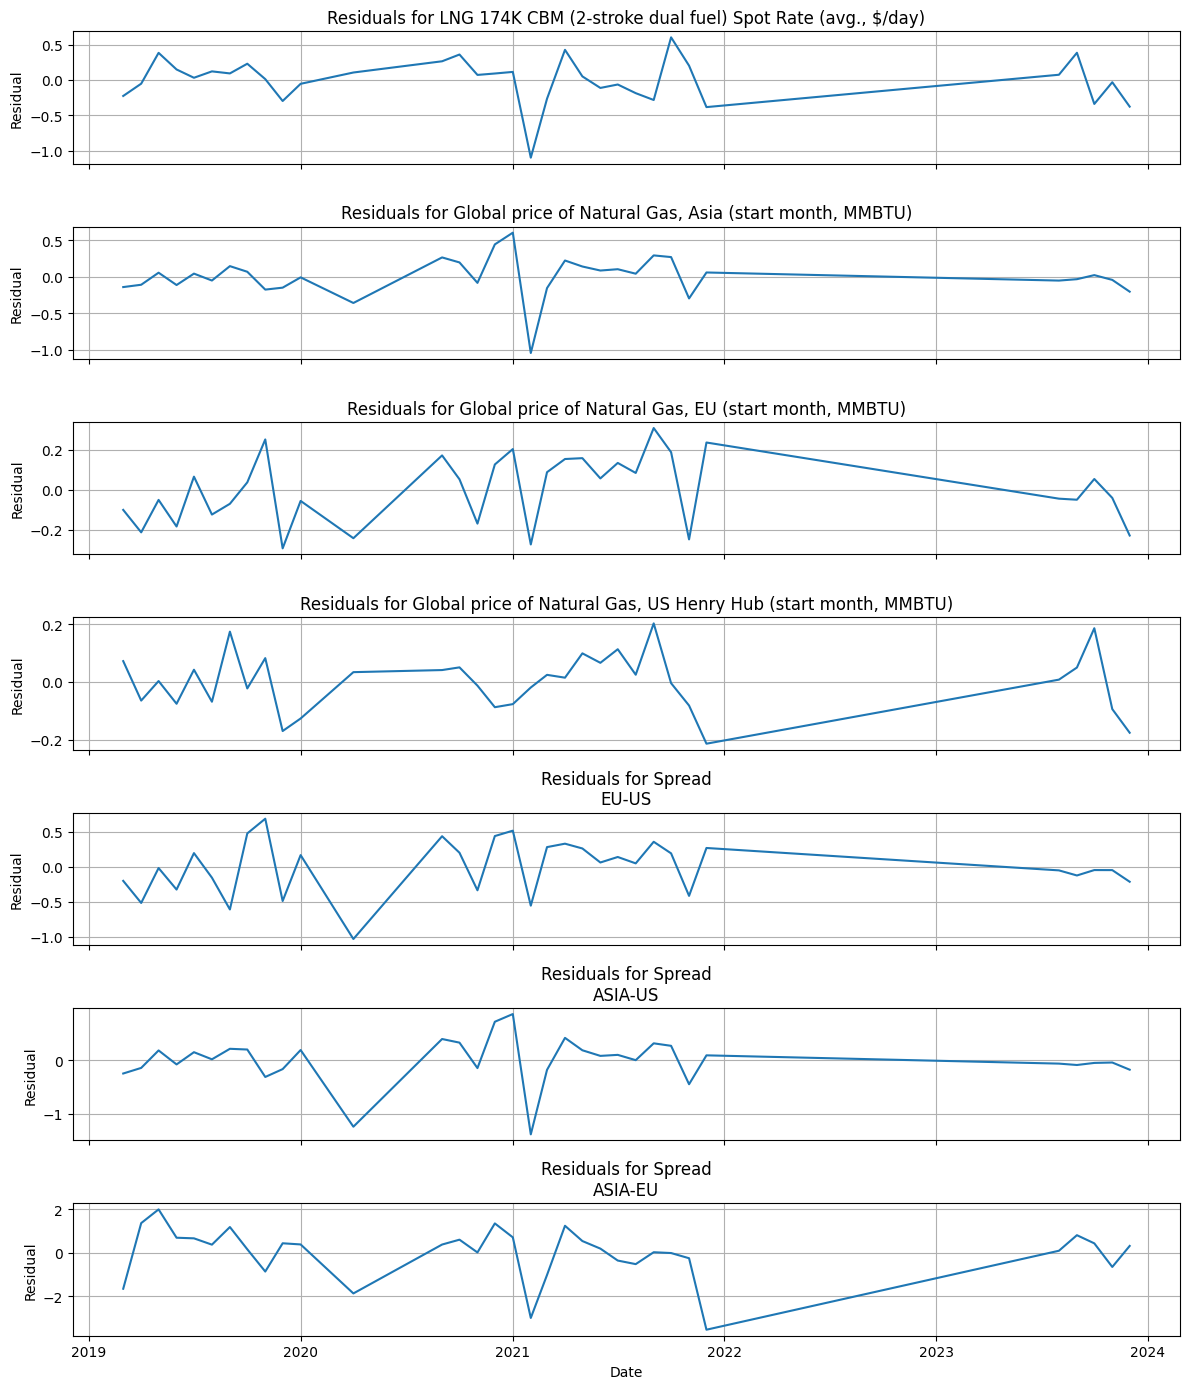

In [6]:
#Alt.1 Gas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR


file_path = "../cleandata.csv"
df_clean = pd.read_csv(file_path)
df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')

forecast_data = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
                 'Global price of Natural Gas, Asia (start month, MMBTU)',
                 'Global price of Natural Gas, EU (start month, MMBTU)',
                 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
                 'Spread\nEU-US',
                 'Spread\nASIA-US',
                 'Spread\nASIA-EU']

forecast_start_date = pd.to_datetime("2024-01-01")
df_temp = df_clean[forecast_data].copy()
df_train = df_temp[df_temp.index < forecast_start_date]
df_train = np.log(df_train).diff().dropna()

model = VAR(df_train)
selected_lag = model.select_order(maxlags=2).aic
if selected_lag is None or selected_lag == 0:
    selected_lag = 1
results = model.fit(maxlags=selected_lag)

residuals = results.resid

fig, axs = plt.subplots(len(forecast_data), figsize=(12, 2 * len(forecast_data)), sharex=True)
for i, col in enumerate(forecast_data):
    if col in residuals.columns:
        axs[i].plot(residuals.index, residuals[col])
        axs[i].set_title(f"Residuals for {col}")
        axs[i].set_ylabel("Residual")
        axs[i].grid(True)
plt.xlabel("Date")
plt.tight_layout()
plt.show()


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


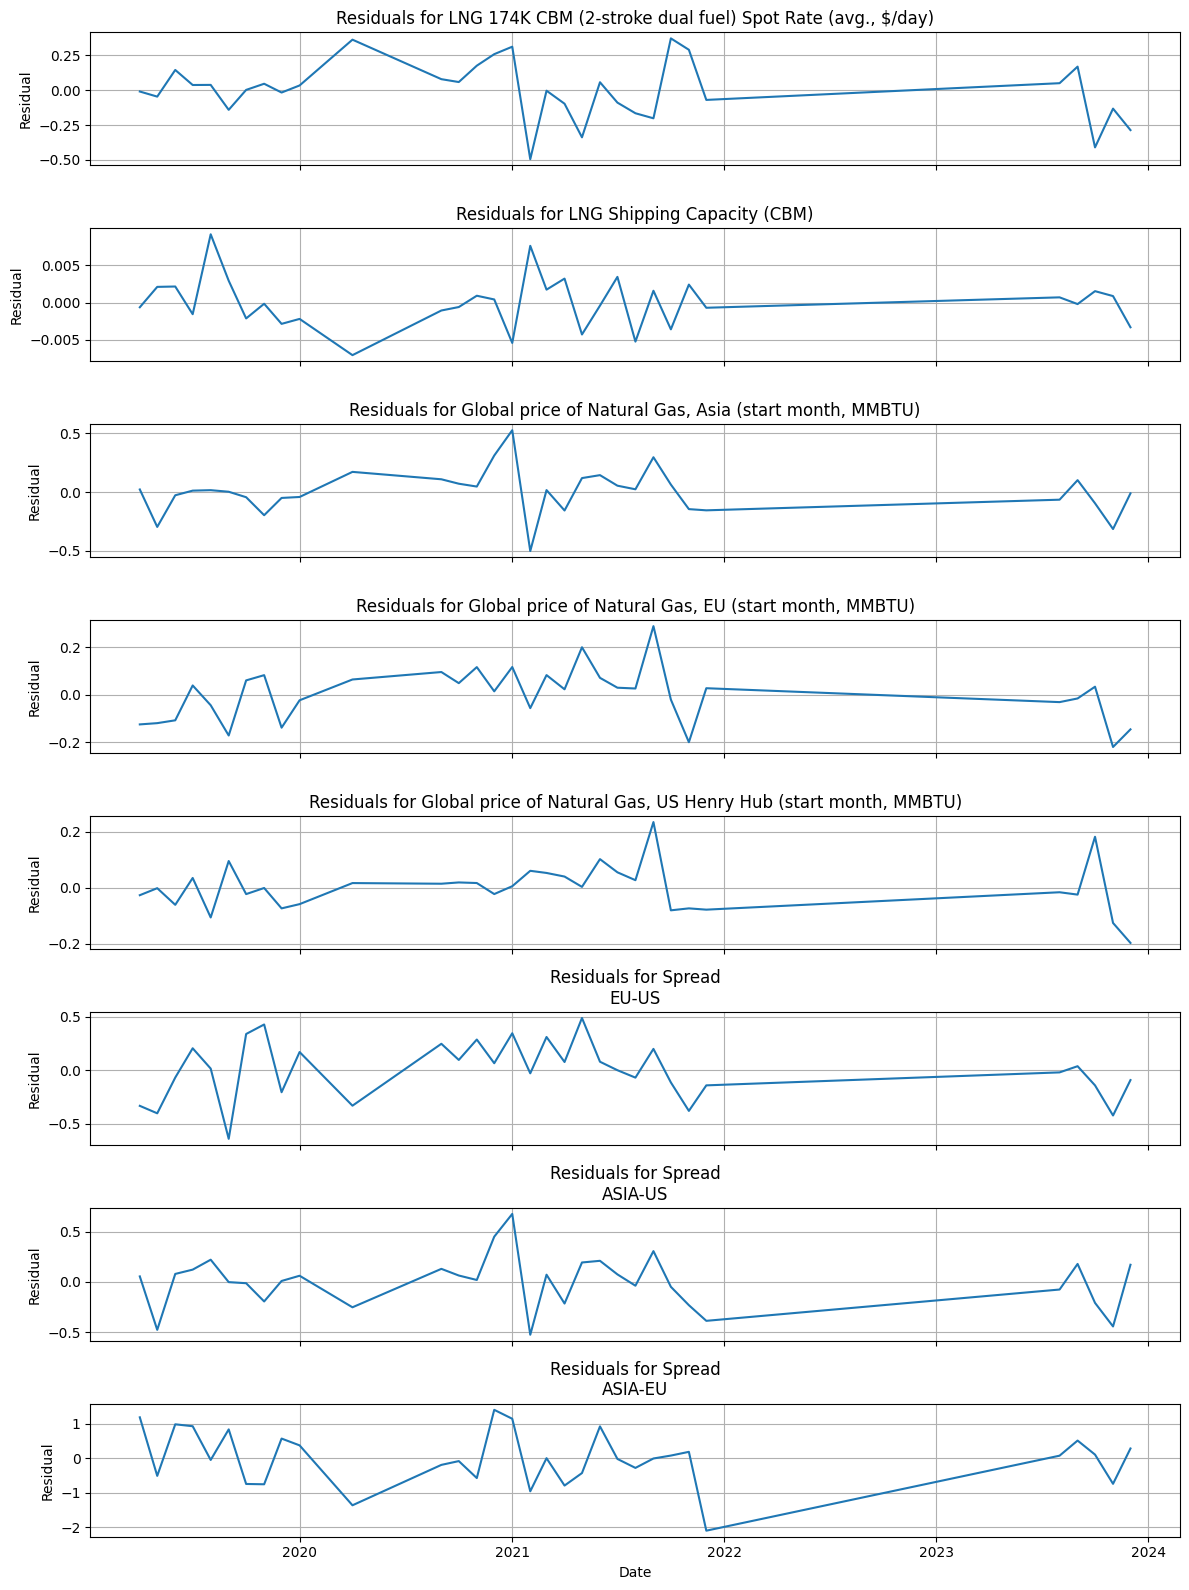

In [3]:
#Alt.2 Gas + Fleet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR


file_path = "../cleandata.csv"
df_clean = pd.read_csv(file_path)
df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')

forecast_data = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
                 'LNG Shipping Capacity (CBM)',
                 'Global price of Natural Gas, Asia (start month, MMBTU)',
                 'Global price of Natural Gas, EU (start month, MMBTU)',
                 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
                 'Spread\nEU-US',
                 'Spread\nASIA-US',
                 'Spread\nASIA-EU']

forecast_start_date = pd.to_datetime("2024-01-01")
df_temp = df_clean[forecast_data].copy()
df_train = df_temp[df_temp.index < forecast_start_date]
df_train = np.log(df_train).diff().dropna()

model = VAR(df_train)
selected_lag = model.select_order(maxlags=2).aic
if selected_lag is None or selected_lag == 0:
    selected_lag = 1
results = model.fit(maxlags=selected_lag)

residuals = results.resid

fig, axs = plt.subplots(len(forecast_data), figsize=(12, 2 * len(forecast_data)), sharex=True)
for i, col in enumerate(forecast_data):
    if col in residuals.columns:
        axs[i].plot(residuals.index, residuals[col])
        axs[i].set_title(f"Residuals for {col}")
        axs[i].set_ylabel("Residual")
        axs[i].grid(True)
plt.xlabel("Date")
plt.tight_layout()
plt.show()


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


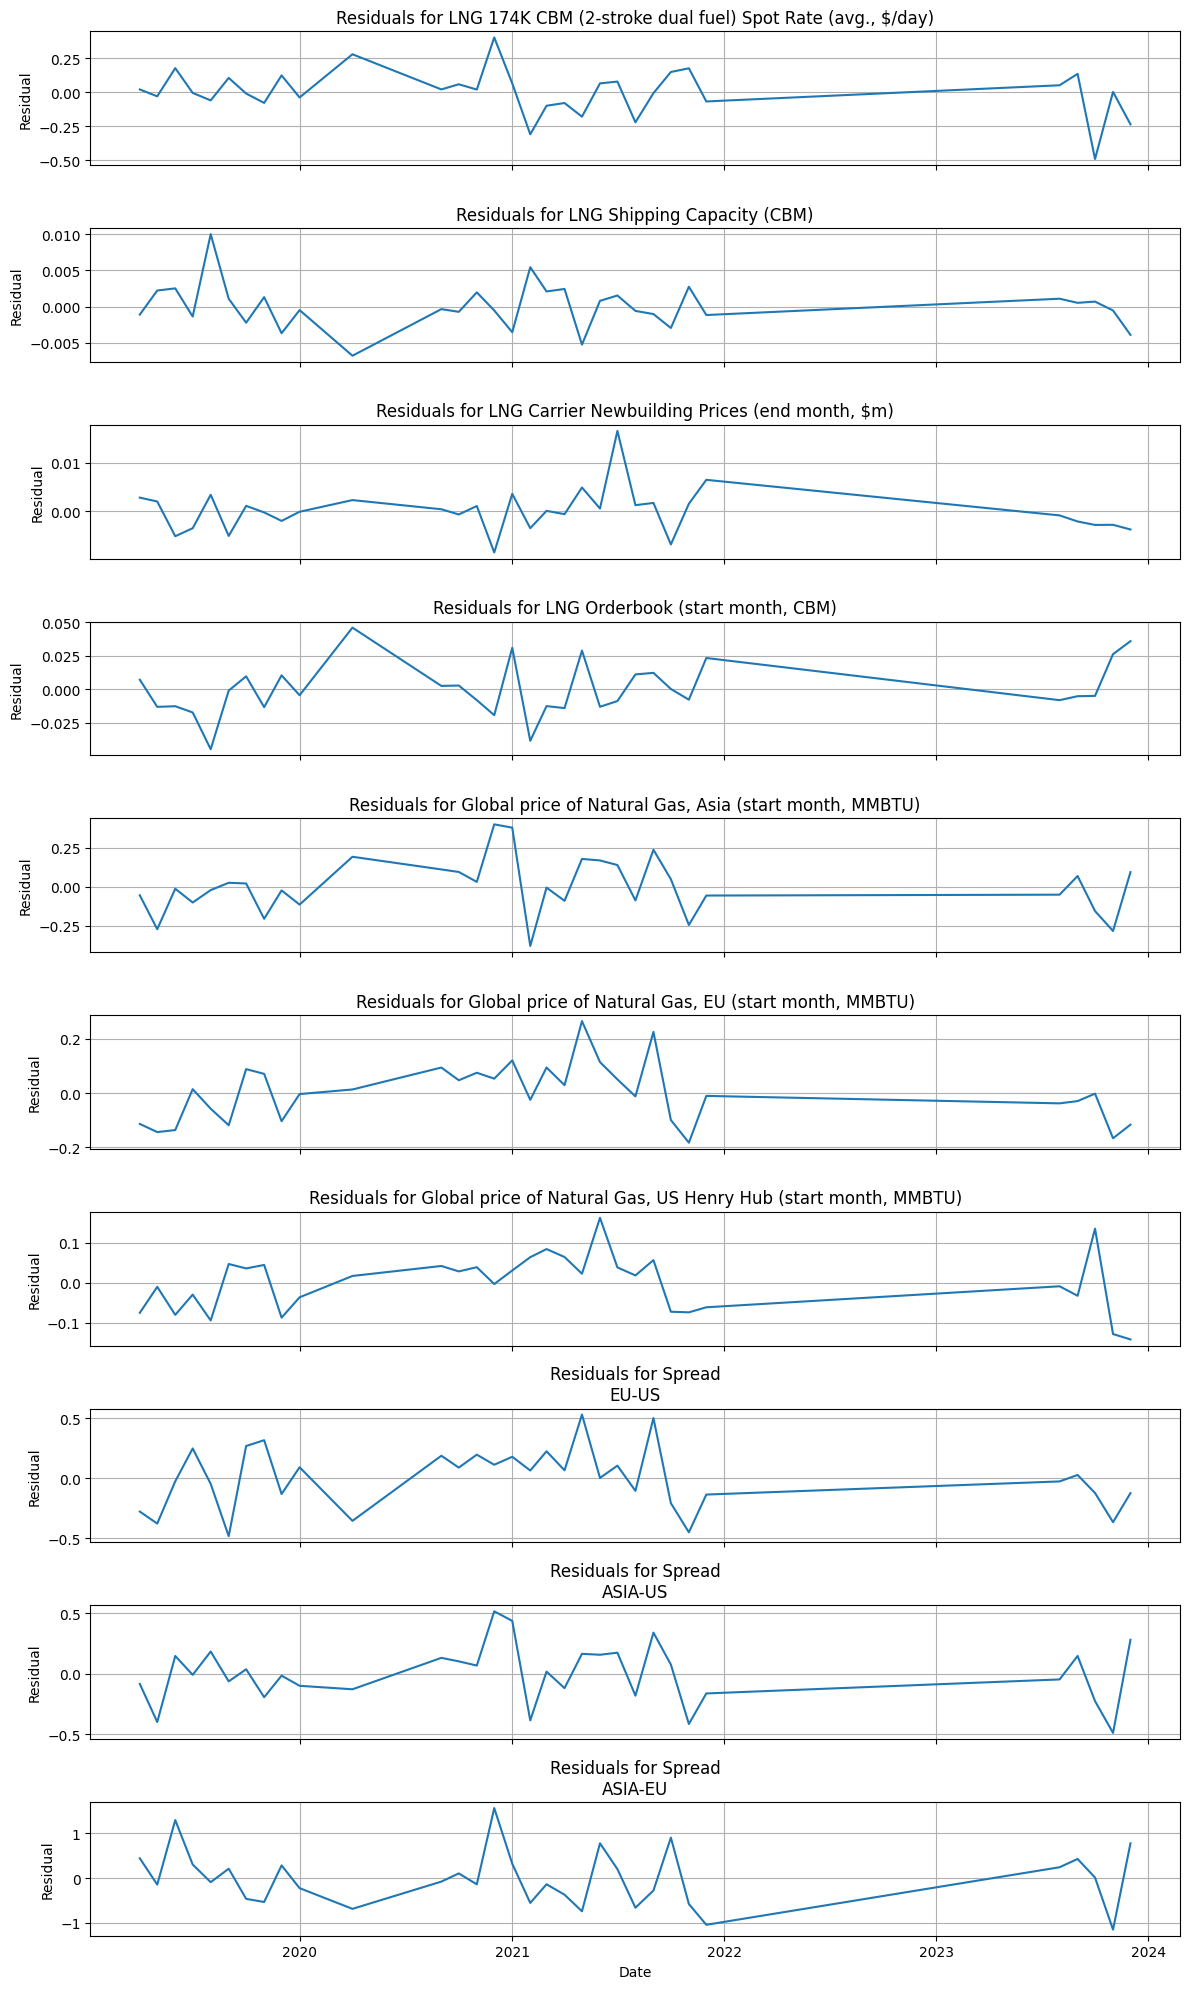

In [2]:
#Full model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR


file_path = "../cleandata.csv"
df_clean = pd.read_csv(file_path)
df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')

forecast_data = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
                 'LNG Shipping Capacity (CBM)',
                 'LNG Carrier Newbuilding Prices (end month, $m)',
                 'LNG Orderbook (start month, CBM)',
                 'Global price of Natural Gas, Asia (start month, MMBTU)',
                 'Global price of Natural Gas, EU (start month, MMBTU)',
                 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
                 'Spread\nEU-US',
                 'Spread\nASIA-US',
                 'Spread\nASIA-EU']

forecast_start_date = pd.to_datetime("2024-01-01")
df_temp = df_clean[forecast_data].copy()
df_train = df_temp[df_temp.index < forecast_start_date]
df_train = np.log(df_train).diff().dropna()

model = VAR(df_train)
selected_lag = model.select_order(maxlags=2).aic
if selected_lag is None or selected_lag == 0:
    selected_lag = 1
results = model.fit(maxlags=selected_lag)

residuals = results.resid

fig, axs = plt.subplots(len(forecast_data), figsize=(12, 2 * len(forecast_data)), sharex=True)
for i, col in enumerate(forecast_data):
    if col in residuals.columns:
        axs[i].plot(residuals.index, residuals[col])
        axs[i].set_title(f"Residuals for {col}")
        axs[i].set_ylabel("Residual")
        axs[i].grid(True)
plt.xlabel("Date")
plt.tight_layout()
plt.show()
